# Attentionの可視化
Attention付きseq2seqモデルを事前に学習してパラメータファイルを保存しておいてください。  
また、matplotlibの設定ファイルを編集して日本語フォントを指定しないと文字化けします

In [1]:
import sys
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from data.sequence import TextSequence
from attention_seq2seq import AttentionSeq2seq, AttentionSeq2seqBiLSTM

In [2]:
# matplotlibのインライン表示
%matplotlib inline
# モジュールの更新時に自動で再読み込み
%reload_ext autoreload
%autoreload 2

In [3]:
# ディレクトリパスの設定
dataset_dir =Path('../dataset')
result_dir = Path('../results')
model_dir = Path('../models')

In [4]:
# ファイルパスの設定
vocab_csv = [dataset_dir / "translator_gene-con_rev3.csv", dataset_dir / "translator_tori_rev2.csv"]
source_csv = dataset_dir / "translator_gene-con_rev3.csv"
# source_csv = dataset_dir / "translator_tori_rev2.csv"
dataset_name = source_csv.stem
encoding = "utf-8"

In [5]:
# Attentionモデルのパラメータファイル
pickle_path = model_dir / "translator_gene-con_rev3_AttentionSeq2seqBiLSTM_V428_D128_H128_190221_1622.pkl"

## 前処理
### データセット読み込み

In [6]:
# 全てのデータセットを読み込み、Vocabularyを作成する
seq = TextSequence()
for path in vocab_csv:
    seq.read_csv(path)
char_to_id, id_to_char = seq.vocab

In [7]:
# 対象のデータセットを読み込み
seq.read_csv(source_csv)

(array([[  4,   5,   6, ...,   0,   0,   0],
        [  4,   5,   6, ...,   0,   0,   0],
        [  4,  15,   5, ...,  26,  27,   7],
        ...,
        [123, 124,  24, ...,   0,   0,   0],
        [123, 124,  24, ...,   0,   0,   0],
        [123, 124,  24, ...,   0,   0,   0]]),
 array([[ 1,  8, 21, ...,  0,  0,  0],
        [ 1,  8, 21, ...,  0,  0,  0],
        [ 1,  8, 21, ..., 23, 12,  2],
        ...,
        [ 1, 17, 10, ...,  0,  0,  0],
        [ 1, 17, 10, ...,  0,  0,  0],
        [ 1, 17, 10, ...,  0,  0,  0]]))

### ハイパーパラメータ設定

In [8]:
# ハイパーパラメータ
vocab_size = len(char_to_id)
wordvec_size = 128
hidden_size = 128
batch_size = 32

In [9]:
vocab_size

428

In [10]:
# データセット分割
x_train, x_test, t_train, t_test = seq.split_data(seed=1, test_size=0.1)

### model, optimizer, trainerインスタンス作成

In [11]:
# model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model = AttentionSeq2seqBiLSTM(vocab_size, wordvec_size, hidden_size)

In [12]:
model.load_params(file_name=str(pickle_path))

## 可視化関数

In [27]:
def visualize(attention_map, row_labels, column_labels):
    fig = plt.figure(figsize=(15, 15), dpi=200)
    ax = fig.add_subplot(3, 2, 1)
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.tick_params(axis='both', labelsize=4)
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    plt.show()

Input: 強化ガラスt=10mm
Teacher: PT10


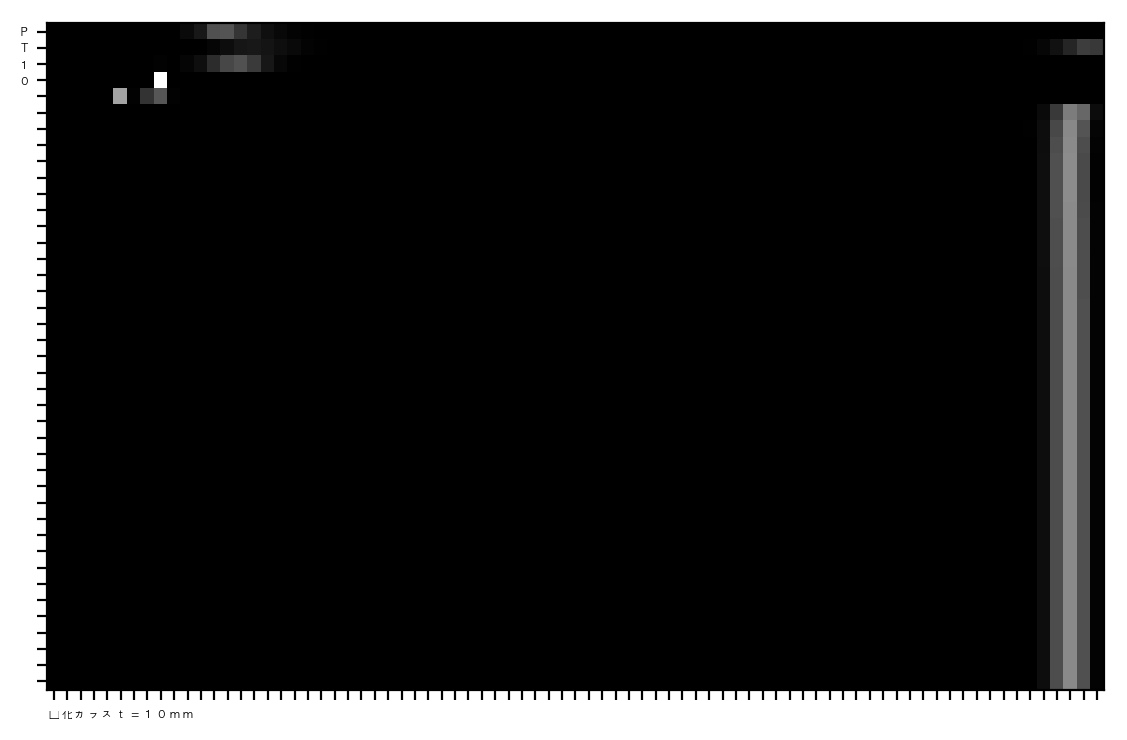

Input: 透明耐熱強化ガラス06.5(飛散防止フィルム)
Teacher: FR6.5


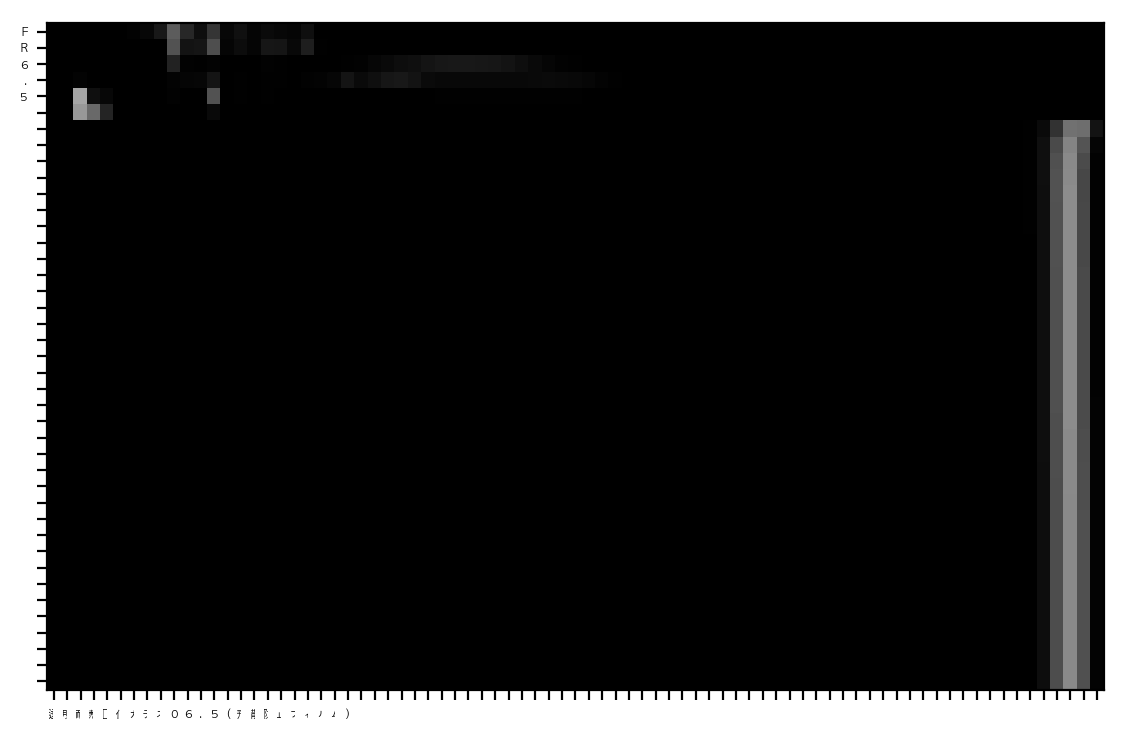

Input: Low-E6.0+A6+FL5.0
Teacher: LowE6+A6+FL5


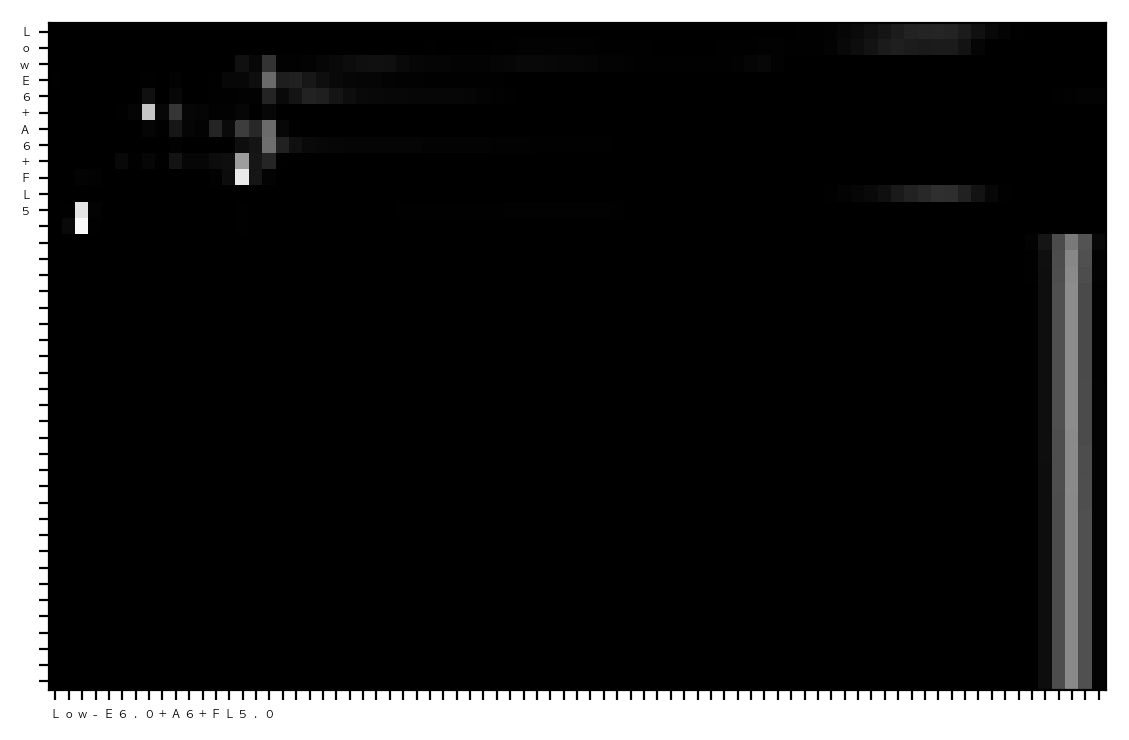

In [34]:
np.random.seed(10)
for _ in range(3):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # reverse for print
    attention_map = attention_map[:,::-1]

    row_labels = [id_to_char[i] for i in x[0] if i > 3]
    column_labels = [id_to_char[i] for i in t[0] if i > 3]
#     column_labels = column_labels[1:]
    print("Input:", ''.join(row_labels))
    print("Teacher:", ''.join(column_labels))

    visualize(attention_map, row_labels, column_labels)